In [1]:
import pandas as pd
import os
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
from scipy.spatial.transform import Rotation as R
#from matplotlib.colors import LogNorm, Normalize

In [52]:
# Pyplot Setup
sns.set_theme(style="ticks", palette="pastel")
import matplotlib as mpl
plt.style.use(r'F:\DATA_F\JPCB_fig_publish_svg\publish.mplstyple')

In [53]:
def save_to_svg(filename, root_path='F:\DATA_F\JPCB_fig_publish_svg'):
    plt.savefig(os.path.join(root_path,filename))

In [4]:
target_dir=r'F:\DATA_F\Entropy_Force_raw_data'
os.chdir(target_dir)
protein_entry=pd.read_csv('Disprot_DP_simulation_stat.csv')
full_df=pd.read_csv('Disprot_DP_entropic_force.csv')
ref_df=pd.read_csv('Disprot_DP_ensemble_data.csv')

In [5]:
#GS_data
target_dir_gs=r'F:\DATA_F\Entropy_Force_raw_data'
os.chdir(target_dir_gs)
protein_entry_gs=pd.read_csv('GS_linker_simulation_stat.csv')
full_df_gs=pd.read_csv('GS_linker_entropic_force.csv')
ref_df_gs=pd.read_csv('GS_linker_ensemble_data.csv')

In [6]:
target_dir=r'F:\DATA_F\Entropy_Force_raw_data'
os.chdir(target_dir)
protein_entry_puma=pd.read_csv('PUMA_simulation_stat.csv')
full_df_puma=pd.read_csv('PUMA_entropic_force.csv')
ref_df_puma=pd.read_csv('PUMA_ensemble_data.csv')

In [7]:
def c_mean_cal(a):
    """
    
    Parameters
    ----------
    a : np.ndarray, shape=(d.n_frames,3)
        principal moment array of the input trajectory
        a[0]<=a[1]<=a[2]

    Returns
    -------
    .. math::
        
        \frac{a_1a_2+a_2a_3+a_3a_1}{(a_1+a_2+a_3)^2}

    """
    return (a[:,0]*a[:,1]+a[:,1]*a[:,2]+a[:,2]*a[:,0])/(a[:,0]+a[:,1]+a[:,2])**2
def calc_asphericity(d):
    """

    Parameters
    ----------
    d : mdtraj trajectory object. (Only Protein Atoms should be selected)
        target trajectory.

    Returns
    -------
    result : np.ndarray, shape=(d.n_frames,)
        asphericity array
    
    Reference
    -------
    
    Calculate the protein asphericity based on https://openscholarship.wustl.edu/etd/900/

    """
    # Calculate the principal axis

    p_m=md.principal_moments(d)
    result=1-3*c_mean_cal(p_m)
    
    return result

In [8]:
def average_asphericity(t):
    u=t.top.select('protein')
    r=t.atom_slice(u)
    j = r.n_frames
    d = calc_asphericity(r)
    return st.mean(d)

In [9]:
prefix_20="F:\DATA_F\puma_scrammble_sum\puma_scramble_20-summary\BB\S_0"

In [10]:
traj_20=md.load([os.path.join(prefix_20, "".join(["__traj_",str(x),".xtc"])) for x in range(3)],
                top=os.path.join(prefix_20,"__START_0.pdb"))

In [11]:
def get_xyz_alpha(traj):
    u=traj.top.select('protein')
    r=traj.atom_slice(u)
    r_alpha=traj.topology.select_atom_indices(selection='alpha')
    return r.xyz[:,r_alpha,:]

In [12]:
xyz_np_20=get_xyz_alpha(traj_20)

In [13]:
def align(traj_xyz):
    result=np.zeros_like(traj_xyz)
    for index, i in enumerate(traj_xyz):
        objectframe=i[:,:]
        object_ori=objectframe[:,:]-objectframe[0,:]
        a1a2=object_ori[1,:]
        az=[0,0,1]
        normal_vec=np.cross(a1a2,az)
        angle=np.arccos(np.dot(a1a2,az)/np.linalg.norm(a1a2))
        unit_normal_vec=normal_vec/np.linalg.norm(normal_vec)
        rot_vec=angle*unit_normal_vec
        r=R.from_rotvec(rot_vec)
        result[index]=r.apply(object_ori)
    return result

In [14]:
xyz_plot_20=align(xyz_np_20)

In [48]:
def contor_map_ax(input_np,fig,ax,title,xlim=(-10,10),ylim=(-10,10),length=0,asphericity=0,DeltaS=0):
    reshape_np=input_np.reshape(-1,3)
    counts,xbins,ybins,image=ax.hist2d(reshape_np[:,0],reshape_np[:,2],bins=np.linspace(-12,12,61),density=True,norm=mpl.colors.LogNorm(vmin=0.0001,vmax=1),cmap='Greys',range=[[-12,12],[-12,12]])
    print(np.sum(counts)*(xbins[0]-xbins[1])*(ybins[0]-ybins[1]))
    ax.set_title(title,fontsize=40)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #fig.colorbar(image, ax=ax)
    ax.contour(counts.T,levels=np.logspace(-4,0,num=6),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)
    ax.plot([-15,15],[0,0],'--',c='black')
    ax.plot([0,0],[-15,15],'--',c='black')
    ax.axhspan(-15,0,facecolor='red',alpha=0.1)
    ax.set_xlabel(str(length)+'AA',fontsize=20)
    ax.set_ylabel('$\delta$={:.2f} \n $\Delta S/k_B$={:.2f}'.format(asphericity,DeltaS),fontsize=20)
    return image
    #plt.ylim(-5,5)
    #plt.xlim(-5,5)
    #plt.xlabel('X')
    #plt.ylabel('Z')

C:\Users\small\AppData\Local\Temp/ipykernel_15012/3723711048.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  image=contor_map_ax(xyz_plot_20,fig,ax,title='PUMA s20',xlim=(-7,7),ylim=(-7,7),length=34,asphericity=average_asphericity(traj_20),DeltaS=np.log(full_df_puma[(full_df_puma['Protein']=='puma_scramble_20')&(full_df_puma['prot_solv_inter']==0)].mean()['OmegaT/OmegaU']))


1.000000000000002


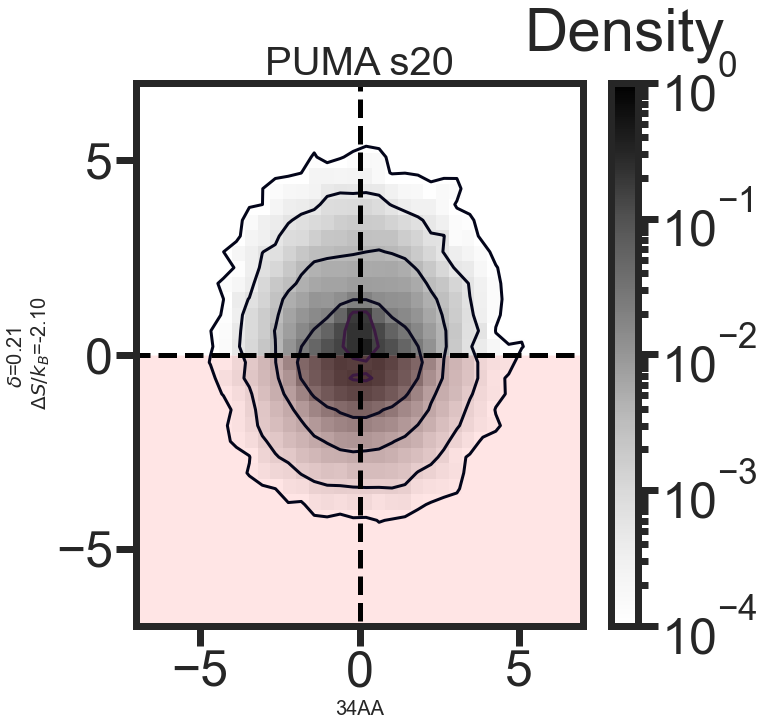

In [54]:
fig,ax=plt.subplots()
image=contor_map_ax(xyz_plot_20,fig,ax,title='PUMA s20',xlim=(-7,7),ylim=(-7,7),length=34,asphericity=average_asphericity(traj_20),DeltaS=np.log(full_df_puma[(full_df_puma['Protein']=='puma_scramble_20')&(full_df_puma['prot_solv_inter']==0)].mean()['OmegaT/OmegaU']))
cbar=fig.colorbar(image, ax=ax)
cbar.ax.set_title('Density',y=1.05)
save_to_svg('colorbar.svg')

In [34]:
prefix_GS16='F:\DATA_F\GSlinker_entropic_force_with_GS4\GS16-summary\BB\S_0'
traj_GS16=md.load([os.path.join(prefix_GS16, "".join(["__traj_",str(x),".xtc"])) for x in range(5)],
                top=os.path.join(prefix_GS16,"__START_0.pdb"))
xyz_np_GS16=get_xyz_alpha(traj_GS16)
xyz_plot_GS16=align(xyz_np_GS16)
print('Average Asphericity: {:.2f}'.format(average_asphericity(traj_GS16)))

Average Asphericity: 0.40


In [35]:
prefix_0720='F:\DATA_F\PDB_1009\DP00720-summary\BB\S_0'
traj_0720=md.load([os.path.join(prefix_0720, "".join(["__traj_",str(x),".xtc"])) for x in range(5)],
                top=os.path.join(prefix_0720,"__START_0.pdb"))
xyz_np_0720=get_xyz_alpha(traj_0720)
xyz_plot_0720=align(xyz_np_0720)
print('Average Asphericity: {:.2f}'.format(average_asphericity(traj_0720)))

Average Asphericity: 0.62


C:\Users\small\AppData\Local\Temp/ipykernel_15012/2522102886.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  contor_map_ax(xyz_plot_20,fig,axes[0],title='PUMA s20',xlim=(-7,7),ylim=(-7,7),length=34,asphericity=average_asphericity(traj_20),DeltaS=np.log(full_df_puma[(full_df_puma['Protein']=='puma_scramble_20')&(full_df_puma['prot_solv_inter']==0)].mean()['OmegaT/OmegaU']))


1.000000000000002


C:\Users\small\AppData\Local\Temp/ipykernel_15012/2522102886.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  contor_map_ax(xyz_plot_GS16,fig,axes[1],title='GS16',xlim=(-10,10),ylim=(-10,10),length=32,asphericity=average_asphericity(traj_GS16),DeltaS=np.log(full_df_gs[(full_df_gs['Protein']=='GS16')&(full_df_gs['prot_solv_inter']==0)].mean()['OmegaT/OmegaU']))


1.0000000000000016


C:\Users\small\AppData\Local\Temp/ipykernel_15012/2522102886.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  contor_map_ax(xyz_plot_0720,fig,axes[2],title='dSSRP1',xlim=(-12,12),ylim=(-12,12),length=36,asphericity=average_asphericity(traj_0720),DeltaS=np.log(full_df[(full_df['Protein']=='DP00720')&(full_df['prot_solv_inter']==0)].mean()['OmegaT/OmegaU']))


1.0000000000000016


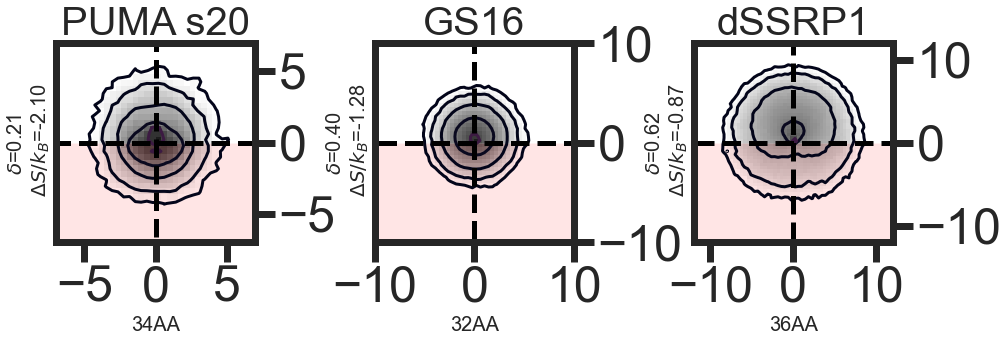

In [55]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
contor_map_ax(xyz_plot_20,fig,axes[0],title='PUMA s20',xlim=(-7,7),ylim=(-7,7),length=34,asphericity=average_asphericity(traj_20),DeltaS=np.log(full_df_puma[(full_df_puma['Protein']=='puma_scramble_20')&(full_df_puma['prot_solv_inter']==0)].mean()['OmegaT/OmegaU']))
contor_map_ax(xyz_plot_GS16,fig,axes[1],title='GS16',xlim=(-10,10),ylim=(-10,10),length=32,asphericity=average_asphericity(traj_GS16),DeltaS=np.log(full_df_gs[(full_df_gs['Protein']=='GS16')&(full_df_gs['prot_solv_inter']==0)].mean()['OmegaT/OmegaU']))
contor_map_ax(xyz_plot_0720,fig,axes[2],title='dSSRP1',xlim=(-12,12),ylim=(-12,12),length=36,asphericity=average_asphericity(traj_0720),DeltaS=np.log(full_df[(full_df['Protein']=='DP00720')&(full_df['prot_solv_inter']==0)].mean()['OmegaT/OmegaU']))
for i in range(3):
        axes[i].set_box_aspect(1)
        axes[i].yaxis.tick_right()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6)
#fig.text(0.5, 1.01, 'XZ-plane for aligned ensembles', ha='center', fontsize=40)
save_to_svg('Fig5C.svg')